# Deep Learning Project | Ampalaya Leaf NPK Deficiency Detection | ResNet50

In [1]:
# TensorFlow and Keras for model building
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
# Other utilities
import os
import numpy as np
import matplotlib.pyplot as plt


Constants

In [2]:
IMAGE_SIZE = 299
BATCH_SIZE = 128
CLASSES = 4
EPOCHS = 60

: 

Dataset directory declaration

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"C://Users//REYES//OneDrive//Desktop//CNN_Projects//DATASETS//AMPALAYA_DS", #Folder name or directory
shuffle=True,
image_size=(IMAGE_SIZE, IMAGE_SIZE),
batch_size=BATCH_SIZE
)

#Calls and Displays class names from dataset
class_names = dataset.class_names
class_names

Found 2300 files belonging to 4 classes.


['Healthy',
 'Nitrogen Deficient',
 'Phosphorus Deficient',
 'Potassium Deficient']

In [ ]:
import pandas as pd
import seaborn as sns

sns.set(rc={'axes.facecolor': '#d4d4d4', 'figure.facecolor': '#fffcfc'})

# Function to count images in each folder
def images_count(path, name):
    count = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            count[folder] = len(os.listdir(folder_path))
            print(f'\033[1mNumber of Images in {folder}: {count[folder]}\033[0m')
    # Create DataFrame and prepare it for plotting
    df = pd.DataFrame(count, index=[name]).melt(var_name='class').sort_values(by='value', ascending=False)
    return df

# Get the image count DataFrame
class_count = images_count("C://Users//REYES//OneDrive//Desktop//CNN_Projects//DATASETS//AMPALAYA_DS", "Healthy")

# Plot the barplot
ax = sns.barplot(data=class_count, x='class', y='value', edgecolor='black', linewidth=2, alpha=0.8)

# Manually adjust the width of the bars
for bar in ax.patches:
    bar.set_width(0.7)

# Customize the axes labels and ticks
plt.xticks(rotation=90, color='black', weight='bold')
plt.yticks(color='black', weight='bold')
plt.xlabel('Class', weight='bold', fontsize=14)
plt.ylabel('Frequency', weight='bold', fontsize=14)

# Disable grid lines
plt.grid(False)

# Display the plot
plt.show()

# Plot 3 images each from their respective classes

In [ ]:
# Assuming 'dataset' is a tf.data.Dataset object and class_names is defined
class_names_of_interest = ['Healthy', 'Nitrogen Deficient', 'Phosphorus Deficient', 'Potassium Deficient']
class_indices = [class_names.index(name) for name in class_names_of_interest]  # Get class indices

healthy_images = {name: [] for name in class_names_of_interest}  # Create a dictionary to store images

# Extract images for the specified classes from the dataset
for images, labels in dataset:
    for i in range(len(labels)):
        label = labels[i].numpy()  # Convert to numpy for easier comparison
        if label in class_indices and len(healthy_images[class_names[label]]) < 3:
            healthy_images[class_names[label]].append((images[i], labels[i]))  # Store image and label
        # Stop collecting images if all three classes have 3 images each
        if all(len(healthy_images[name]) == 3 for name in class_names_of_interest):
            break
    if all(len(healthy_images[name]) == 3 for name in class_names_of_interest):
        break

# Plot the images for each class
plt.figure(figsize=(15, 15))
for i, name in enumerate(class_names_of_interest):
    for j, (image, label) in enumerate(healthy_images[name]):
        ax = plt.subplot(len(class_names_of_interest), 3, i * 3 + j + 1)  # Each class in a row
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(name)  # Set title to class name
        plt.axis("off")

plt.tight_layout()
plt.show()

# Splitting Dataset to 80-10-10, training, validation and test respectively
# Apply Augmentation

In [4]:
# Function for augmenting images using preprocessing layers
def Crop(image):
    image = keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)(image)  # Randomly crop image

    return image

def Rotate(image):
    image = keras.layers.RandomRotation(0.4)(image)  # Randomly rotate image

    return image

def Contrast(image):
    image = keras.layers.RandomContrast(0.1)(image)  # Randomly adjust contrast

    return image

def Flip(image):
    image = keras.layers.RandomFlip("horizontal_and_vertical")(image)  # Randomly flip image

    return image

def Brightness(image):
    image = keras.layers.RandomBrightness([0.1, 0.2])(image)  # Randomly adjust brightness

    return image

# Function for augmenting images using preprocessing layers
def augment(image):
    image = keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)(image)  # Randomly crop image
    image = keras.layers.RandomRotation(0.4)(image)  # Randomly rotate image
    image = keras.layers.RandomContrast(0.1)(image)  # Randomly adjust contrast
    image = keras.layers.RandomFlip("horizontal_and_vertical")(image)  # Randomly flip image
    image = keras.layers.RandomBrightness([0.1, 0.2])(image)  # Randomly adjust brightness

    return image

# Load and augment the training set
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000, augment_data=True):
    
    # Get length of dataset
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)  # Shuffle dataset before splitting
    
    # Compute percentage accordingly from dataset size
    train_size = int(train_split * ds_size) 
    val_size = int(val_split * ds_size) 
    
    # Split the dataset into training, validation, and test sets
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    if augment_data:
    # Apply augmentation only to the training set
        #augmented_train_ds = train_ds.map(lambda x, y: (augment(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        cropped_train_ds = train_ds.map(lambda x, y: (Crop(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        rotated_train_ds = train_ds.map(lambda x, y: (Rotate(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        contrasted_train_ds = train_ds.map(lambda x, y: (Contrast(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        flipped_train_ds = train_ds.map(lambda x, y: (Flip(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        brightness_train_ds = train_ds.map(lambda x, y: (Brightness(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        
    # Concatenate the original training data with the augmented data
       #train_ds = train_ds.concatenate(augmented_train_ds)
        train_ds = train_ds.concatenate(cropped_train_ds)
        train_ds = train_ds.concatenate(rotated_train_ds)
        train_ds = train_ds.concatenate(contrasted_train_ds)
        train_ds = train_ds.concatenate(flipped_train_ds)
        train_ds = train_ds.concatenate(brightness_train_ds)
    
    return train_ds, val_ds, test_ds

# Assuming you already loaded your dataset into `dataset`
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Shuffling and Cache the dataset for faster model training

In [5]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Show train_ds samples. Augmented and Non-Augmented

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

# Load ResNet50 Model

In [52]:
from tensorflow.keras.regularizers import L2

resnet_model = keras.Sequential()

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg', classes=4)
predictions = Dense(4, activation='softmax')

for layer in base_model.layers:
    layer.trainable = False

#Reached 60% F1 score with this one
# resnet_model.add(base_model)
# resnet_model.add(layers.Flatten())
# resnet_model.add(layers.Dense(32, activation='relu', kernel_regularizer=L2(0.01)))
# resnet_model.add(layers.BatchNormalization())
# resnet_model.add(layers.Dropout(0.1))
# resnet_model.add(layers.Dense(32, activation='relu'))
# resnet_model.add(layers.BatchNormalization())

#70 % F1 score great CM
# resnet_model.add(base_model)
# resnet_model.add(layers.Flatten())
# resnet_model.add(layers.Dense(256, activation='relu', kernel_regularizer=L2(0.01)))
# resnet_model.add(layers.BatchNormalization())
# resnet_model.add(layers.Dropout(0.5))
# resnet_model.add(layers.Dense(128, activation='relu', kernel_regularizer=L2(0.01)))
# resnet_model.add(layers.BatchNormalization())

# resnet_model.add(layers.Dense(64, activation='relu', kernel_regularizer=L2(0.01)))
# resnet_model.add(layers.Dropout(0.2))
# resnet_model.add(layers.Dense(64, activation='relu'))
# resnet_model.add(layers.BatchNormalization())

resnet_model.add(base_model)
resnet_model.add(layers.Flatten())

# Regularization and Dropout
resnet_model.add(layers.Dense(512, activation='relu', kernel_regularizer=L2(0.005)))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dropout(0.5))
resnet_model.add(layers.Dense(256, activation='relu', kernel_regularizer=L2(0.005)))
resnet_model.add(layers.BatchNormalization())

resnet_model.add(layers.Dense(128, activation='relu'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dropout(0.3))
resnet_model.add(layers.Dense(128, activation='relu'))

resnet_model.add(layers.Dense(64, activation='relu'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dropout(0.1))
resnet_model.add(layers.Dense(32, activation='relu'))

resnet_model.add(predictions)

resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                      

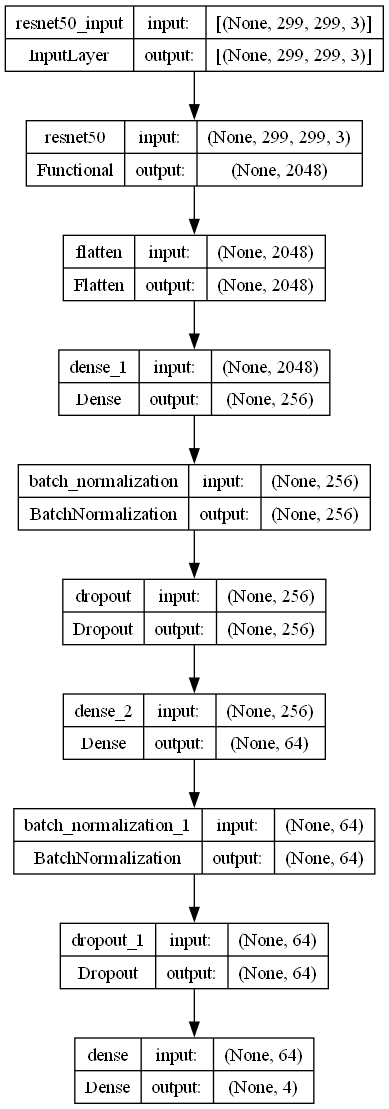

In [7]:
keras.utils.plot_model(resnet_model, show_shapes=True)

In [14]:
# Compile the model with an Adam optimizer and categorical crossentropy loss
resnet_model.compile(optimizer=Adam(learning_rate=0.001, decay=0.01), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# #create a callback function to stop training when the validation loss does not improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [16]:
# Train the model on the dataset
history = resnet_model.fit(
    train_ds,
    epochs=60,  # You can increase the number of epochs based on your dataset
    validation_data=val_ds,
    callbacks=[stop_early, lr_scheduler],
)

Epoch 1/60
72/72 [==============================] - 53s 681ms/step - loss: 2.7134 - accuracy: 0.7893 - val_loss: 2.1957 - val_accuracy: 0.7891 - lr: 0.0010
Epoch 2/60
72/72 [==============================] - 48s 669ms/step - loss: 1.7371 - accuracy: 0.8888 - val_loss: 1.5191 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 3/60
72/72 [==============================] - 49s 674ms/step - loss: 1.3630 - accuracy: 0.9124 - val_loss: 1.1886 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 4/60
72/72 [==============================] - 48s 673ms/step - loss: 1.1375 - accuracy: 0.9299 - val_loss: 1.0186 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 5/60
72/72 [==============================] - 48s 672ms/step - loss: 1.0008 - accuracy: 0.9358 - val_loss: 0.8949 - val_accuracy: 0.9648 - lr: 0.0010
Epoch 6/60
72/72 [==============================] - 48s 672ms/step - loss: 0.8965 - accuracy: 0.9422 - val_loss: 0.8136 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 7/60
72/72 [==============================] - 48s 673ms/st

In [17]:
#show highest accuracy and validation accuracy show lowest loss and validation loss and latest of each
print("Highest Accuracy: ", max(history.history['accuracy']))
print("Highest Validation Accuracy: ", max(history.history['val_accuracy']))
print("Lowest Loss: ", min(history.history['loss']))
print("Lowest Validation Loss: ", min(history.history['val_loss']))
print("Final Accuracy: ", history.history['accuracy'][-1])
print("Final Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Final Loss: ", history.history['loss'][-1])
print("Final Validation Loss: ", history.history['val_loss'][-1])

Highest Accuracy:  0.9940217137336731
Highest Validation Accuracy:  1.0
Lowest Loss:  0.219068244099617
Lowest Validation Loss:  0.19982430338859558
Final Accuracy:  0.9932608604431152
Final Validation Accuracy:  1.0
Final Loss:  0.219068244099617
Final Validation Loss:  0.19982430338859558


# Model Evualuation

In [18]:
scores = resnet_model.evaluate(test_ds) # No Fine-Tuning

4/4 [==============================] - 41s 694ms/step - loss: 0.1995 - accuracy: 1.0000


In [21]:
# code to view f1 score and other metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

4/4 [==============================] - 2s 645ms/step
F1 Score: 0.419921875
Precision: 0.419921875
Recall: 0.419921875
Accuracy: 0.419921875
              precision    recall  f1-score   support

           0       0.40      0.40      0.40       136
           1       0.49      0.49      0.49       140
           2       0.35      0.35      0.35       114
           3       0.43      0.43      0.43       122

    accuracy                           0.42       512
   macro avg       0.42      0.42      0.42       512
weighted avg       0.42      0.42      0.42       512



4/4 [==============================] - 2s 732ms/step


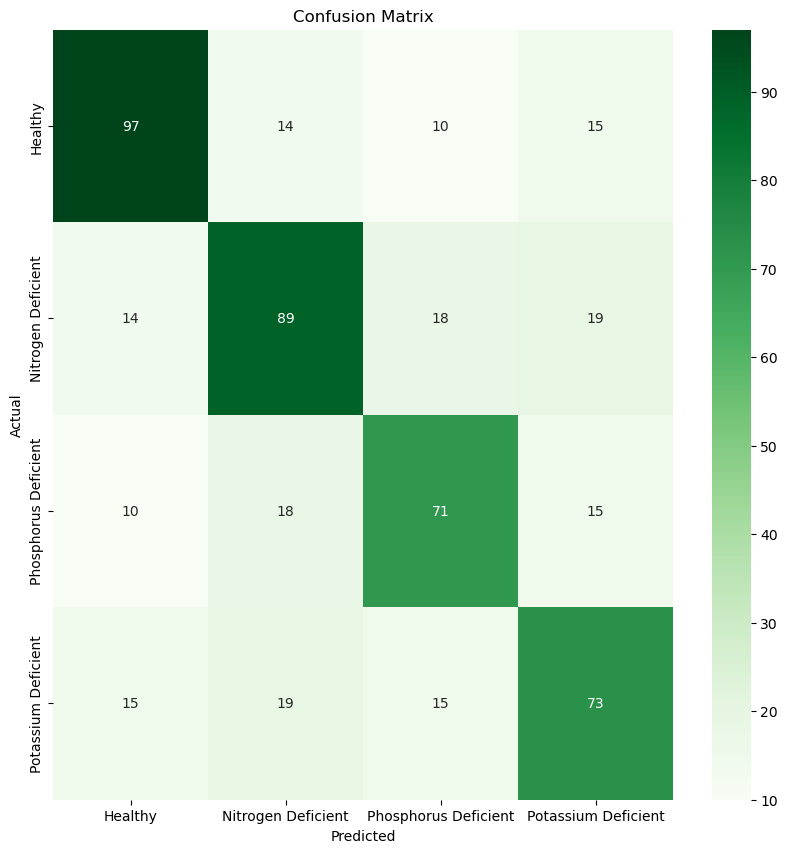

In [22]:
#70-15-15 split 0.001 LR
#code block to show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plotting History | No Fine-Tuning

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

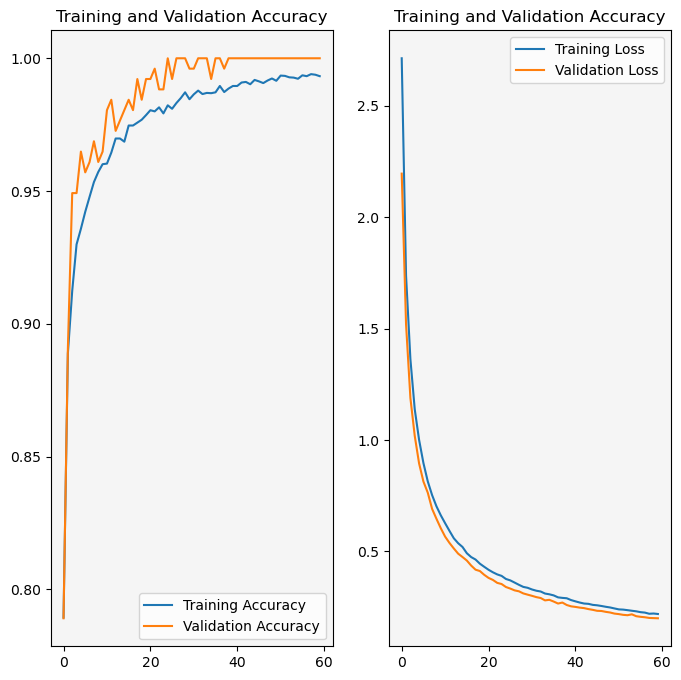

In [51]:
completed_epochs = len(history.history['accuracy'])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(completed_epochs), acc, label='Training Accuracy')
plt.plot(range(completed_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')

plt.subplot(1, 2, 2)
plt.plot(range(completed_epochs), loss, label='Training Loss')
plt.plot(range(completed_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')
plt.show()

# Un-Freeze and Fine-tune the model

In [13]:
resnet_model = keras.models.load_model("C:/Users/REYES/OneDrive/Desktop/CNN_Projects/Ampalaya_ResNet50_Test/notable/GreatCM")
base_model = resnet_model.layers[0]

In [15]:
# Unfreeze only a subset of layers
# for layer in base_model.layers[:120]:  # Freeze the first 100 layers
#     layer.trainable = False
# for layer in base_model.layers[120:]:  # Unfreeze the rest
#     layer.trainable = True

# Freeze all layers except the last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Unfreeze the last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

resnet_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# resnet_model.compile(optimizer=RMSprop(learning_rate=0.001), 
#                loss='sparse_categorical_crossentropy', 
#                metrics=['accuracy'])

# optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

# resnet_model.compile(optimizer=optimizer, 
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])


In [16]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_29 (Dense)            (None, 1024)              2098176   
                                                                 
 batch_normalization_20 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 1024)              0         
                                                                 
 dense_30 (Dense)            (None, 512)               524800    
                                                      

Continue training the entire model

In [26]:
history_finetune = resnet_model.fit(
    train_ds,
    epochs=10,  # Additional epochs for fine-tuning
    batch_size = 64,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
)

Epoch 1/10
48/48 [==============================] - 258s 2s/step - loss: 3.0147 - accuracy: 0.8880 - val_loss: 43.5526 - val_accuracy: 0.3135 - lr: 0.0010
Epoch 2/10
48/48 [==============================] - 52s 1s/step - loss: 2.0094 - accuracy: 0.9641 - val_loss: 1.6660 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 3/10
48/48 [==============================] - 41s 864ms/step - loss: 1.2930 - accuracy: 0.9757 - val_loss: 1.2251 - val_accuracy: 0.9603 - lr: 0.0010
Epoch 4/10
48/48 [==============================] - 41s 864ms/step - loss: 0.8140 - accuracy: 0.9868 - val_loss: 0.8008 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 5/10
48/48 [==============================] - 41s 865ms/step - loss: 0.5065 - accuracy: 0.9901 - val_loss: 0.9902 - val_accuracy: 0.7421 - lr: 0.0010
Epoch 6/10
48/48 [==============================] - 42s 871ms/step - loss: 0.4618 - accuracy: 0.9837 - val_loss: 0.5096 - val_accuracy: 0.9603 - lr: 0.0010
Epoch 7/10
48/48 [==============================] - 42s 873ms/step -

In [74]:
#show highest accuracy and validation accuracy show lowest loss and validation loss and latest of each
print("Highest Accuracy: ", max(history_finetune.history['accuracy']))
print("Highest Validation Accuracy: ", max(history_finetune.history['val_accuracy']))
print("Lowest Loss: ", min(history_finetune.history['loss']))
print("Lowest Validation Loss: ", min(history_finetune.history['val_loss']))
print("Final Accuracy: ", history_finetune.history['accuracy'][-1])
print("Final Validation Accuracy: ", history_finetune.history['val_accuracy'][-1])
print("Final Loss: ", history_finetune.history['loss'][-1])
print("Final Validation Loss: ", history_finetune.history['val_loss'][-1])

Highest Accuracy:  0.9966480731964111
Highest Validation Accuracy:  1.0
Lowest Loss:  0.9205393195152283
Lowest Validation Loss:  0.9031367301940918
Final Accuracy:  0.9958100318908691
Final Validation Accuracy:  1.0
Final Loss:  0.9205393195152283
Final Validation Loss:  0.9031367301940918


In [32]:
# code to view f1 score and other metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# code to view f1 score and other metrics
y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

4/4 [==============================] - 2s 650ms/step
F1 Score: 0.6147959249413586
Precision: 0.6148229012231283
Recall: 0.615234375
Accuracy: 0.615234375
              precision    recall  f1-score   support

           0       0.58      0.61      0.59       135
           1       0.64      0.64      0.64       139
           2       0.55      0.51      0.53       102
           3       0.68      0.68      0.68       136

    accuracy                           0.62       512
   macro avg       0.61      0.61      0.61       512
weighted avg       0.61      0.62      0.61       512



In [33]:
scores = resnet_model.evaluate(test_ds) # With Fine Tuning

4/4 [==============================] - 3s 656ms/step - loss: 0.2103 - accuracy: 0.9727


# Plotting History | With Fine-Tuning

In [34]:
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']

loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']

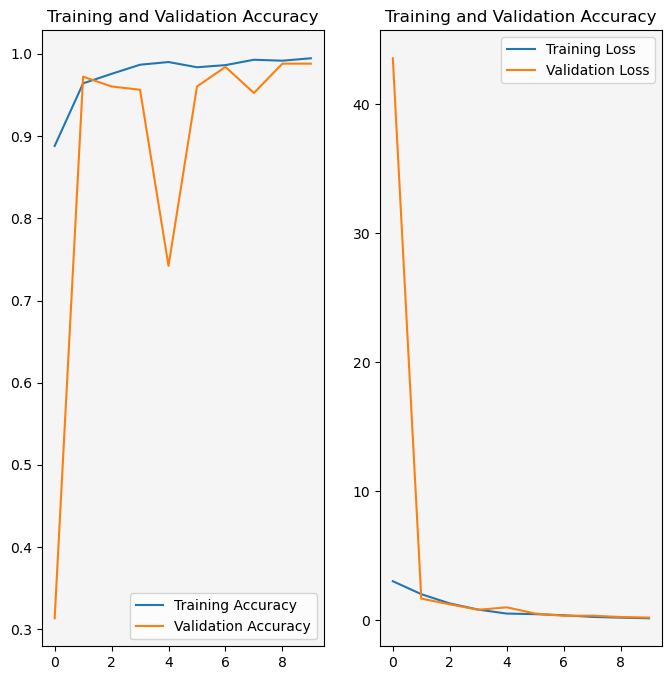

In [35]:
completed_epochs2 = len(history_finetune.history['accuracy'])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(completed_epochs2), acc, label='Training Accuracy')
plt.plot(range(completed_epochs2), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')

plt.subplot(1, 2, 2)
plt.plot(range(completed_epochs2), loss, label='Training Loss')
plt.plot(range(completed_epochs2), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')
plt.show()

# Making a Prediction

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Confusion Matrix

4/4 [==============================] - 2s 702ms/step


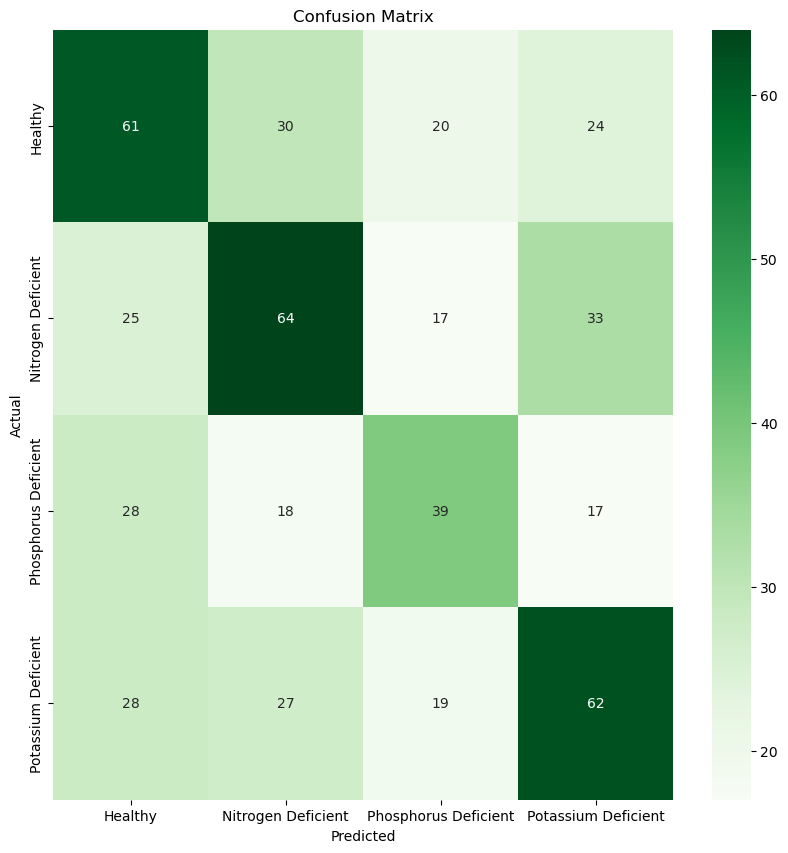

In [37]:
#code block to show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 32ms/step


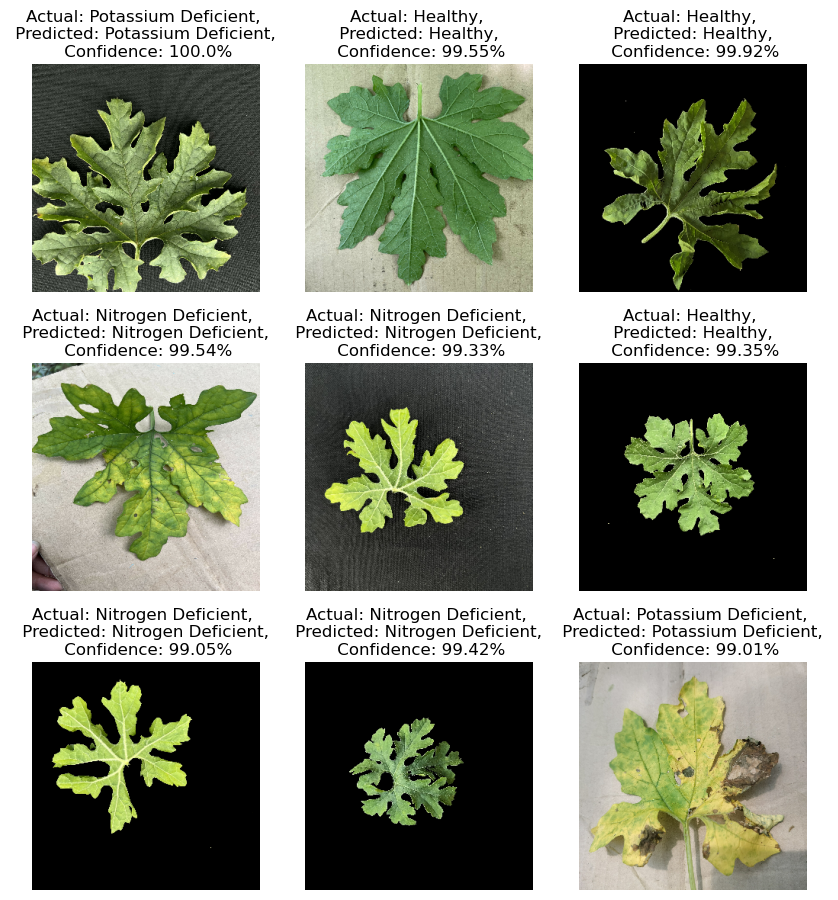

In [38]:
plt.figure(figsize=(10, 11))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(resnet_model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving Model

In [39]:
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
resnet_model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
